##### XGB-Stepregression   
##20220409sym编写 
### 简介：  
使用逐步回归的方法提取最重要的特征相互作用


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
c_time = time.strftime("%Y%m%d_%H%M%S", time.localtime())
c_time_m = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

In [2]:
# 参数
# ======== System Setup ========
Version = 'V1.0sym'
EPOCH = 96
CORE_NUM = 24
# 确保EPOCH*REPEAT_ROUND是CORE_NUM的整数倍
TRAIN_TEST_SPLIT = 0.85
# ======== Fit Data Input ========
S_N = 856
F_N = 50
INPUT_X = 'Features_'+str(S_N)+'_'+str(F_N)+'.csv'
INPUT_Y = 'Values_True_ln_'+str(S_N)+'.csv'
INPUT_TITLE = 'Title_'+str(F_N)+'.csv'
INPUT_SMILES = 'Smiles_'+str(S_N)+'.csv'
RECORD_NAME = 'Record_AFS_'+Version+'_'+c_time+'.txt'

In [3]:
import shap
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn import model_selection
import joblib
from multiprocessing import Pool

In [4]:
import os
from pathlib import Path
DIR = 'SHAP-XGB_'+Version+'_'+c_time
os.mkdir(DIR)
X = np.loadtxt(INPUT_X, delimiter=',')
y = np.loadtxt(INPUT_Y)
title = np.loadtxt(INPUT_TITLE, dtype=str, delimiter=',', comments='!')
smiles = np.loadtxt(INPUT_SMILES, dtype=str, delimiter=',', comments='!')

RECORD_NAME = Path('.', DIR, RECORD_NAME)
f1 = open(RECORD_NAME, 'w')
f1.write('Record of XGB-Stepregression '+Version+'\n\n')
f1.write('Generation time: '+time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())+'\n\n\n')
f1.write('Inputfiles are: '+INPUT_X+'+'+INPUT_Y+'+'+INPUT_TITLE+'+'+INPUT_SMILES+'\n\n\n')
f1.write('EPOCH= '+str(EPOCH)+' CORENUM= '+str(CORE_NUM)+INPUT_X+' splitratio= '+str(round(TRAIN_TEST_SPLIT,3))+'\n\n\n')

60

In [5]:
clf = XGBRegressor(n_estimators=150, learning_rate=0.025, max_depth=13, verbosity=0, booster='gbtree', 
                   reg_alpha=np.exp(-6.788644799030888), reg_lambda=np.exp(-7.450413274554533), gamma=np.exp(-5.374463422208394), 
                   subsample=0.5, objective= 'reg:squarederror', n_jobs=1)
paras = clf.get_params()
mse_list = []
mae_list = []
r2_list = []

In [6]:
def XGB_Fit(X, y, X_train, y_train, X_test, y_test, paras):
    clf_new = XGBRegressor()
    for k, v in paras.items():
        clf_new.set_params(**{k: v})
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    # 拟合模型
    clf_new.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150, verbose=False)
    # 计算损失
    y_pred = clf_new.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    shap_values = shap.TreeExplainer(clf_new).shap_values(X)
#     s = np.mean(clf_new.predict(X))-np.mean(y_train)
#     s2 = np.mean(clf_new.predict(X))-np.mean(y)
#     print(np.sum(shap_values), s, s2)
#     # f_i = clf_new.feature_importances_
#      temp = [mse, mae, r2, shap_values, s, s2]
    temp = [mse, mae, r2, shap_values]
#     print('   MSE: %.5f' % mse, '  MAE: %.5f' % mae, '  R^2: %.5f' % r2)
    del y_pred
    return (temp, 'None')
def flatten(li):
    return sum(([x] if not isinstance(x, list) else flatten(x) for x in li), [])


In [7]:
def poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,X, y, paras):
    r_l = []
    point = round(X.shape[0]*TRAIN_TEST_SPLIT)
    for _ in range(int(EPOCH/CORE_NUM)):
        print('Round', CORE_NUM*(_)+1, 'Begin:')
        pool = Pool(CORE_NUM)
        for __ in range(CORE_NUM):
            permutation = np.random.permutation(y.shape[0])
            train_idx = permutation[:point]
            test_idx = permutation[point:]
            X_train = X[train_idx, :]
            y_train = y[train_idx]
            X_test = X[test_idx, :]
            y_test = y[test_idx]
            r = pool.apply_async(XGB_Fit, args=(X, y, X_train, y_train, X_test, y_test, paras,))
            r_l.append(r)
        pool.close()
        pool.join()
    mse_list=[]
    mae_list=[]
    r2_list=[]
    shap_m = np.zeros((S_N, F_Ntemp))
    for i in range(len(r_l)):
        r = r_l[i]
        results = r.get()
        temp = results[0]
        mse = temp[0]
        mae = temp[1]
        r2 = temp[2]
        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

    mse1=np.mean(mse_list)
    mae1=np.mean(mae_list)
    r21=np.mean(r2_list)
    temp = [mse1, mae1, r21]
    return temp

In [8]:
inifeat='Conju Max Distance (MFF-Conju)'
inifeatindex=np.where(title==inifeat)[0][0]
featlist=[]
featlist1=[]
featlist2=[]
featlist3=[]
featlist4=[]
bestfeatlist=[]
mseind=[]
mselist=[]
for i in range(F_N-1):#for i in range(F_N-1):
    perflist=np.linspace(0,0,len(title))
    print('Now we have ', i+1, 'Features.Begin regression!')
    F_Ntemp=i+1
    if i ==0:
          featlist.append(inifeatindex)
          featlist1=featlist
          print(featlist)
          Xtemp=X[:,featlist]
          print(Xtemp[0])
          perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
          perflist=perf[0]
          print(perflist)      
          featlist2=featlist1
          perf0=perflist
          f1.write('Round 1_'+title[inifeatindex]+'_'+str(round(perf0,4))+'\n')
    else:
          for j in range (F_N):          
                if j!=inifeatindex and mseind !=j:
                    print('j=',j)
                    featlist=[]
                    featlist.append(featlist2)   
                    featlist.append(j)
                    featlist=flatten(featlist)
                    featlist = np.unique(featlist)
                    print('featlist=',featlist)
                    a=np.sort(bestfeatlist)
                    b=a.tolist()
                    if len(featlist)==len(b):                    
                        if all(b==featlist):
                            print('')
                        else:
                            Xtemp=X[:,featlist]
                            print(Xtemp[0])
                            perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
                            perflist[j]=perf[0]
                            print('perflist=',perflist)
                    else:
                        Xtemp=X[:,featlist]
                        print(Xtemp[0])
                        perf=poolfit(TRAIN_TEST_SPLIT,EPOCH,CORE_NUM,Xtemp, y, paras)
                        perflist[j]=perf[0]
                        print('perflist=',perflist)               
          min2 = np.sort(perflist)[i]
          mseind = np.argsort(perflist)[i]
          featlist3=mseind
          print('mseind',mseind)
          featlist4.append(featlist3)
          bestfeatlist=featlist1
          bestfeatlist.append(featlist3)
          print('bestfeatlist=',bestfeatlist)
          featlist2=bestfeatlist
          f1.write('Round '+str(len(title[bestfeatlist]))+'_'+str(title[bestfeatlist])+'_'+str(round(min2,4))+'\n')
          mselist.append(min2)
          print(mselist)
f1.close()

Now we have  1 Features.Begin regression!
[40]
[10.]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
2.2417821684808095
Now we have  2 Features.Begin regression!
j= 0
featlist= [ 0 40]
[24. 10.]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1 40]
[ 2. 10.]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 0.         0.         0.         0.
 0.         0.         0.         0.         0.         

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 2.15094299 2.08691905 2.18421479 2.24524194
 2.14890717 2.14109425 1.90952457 2.3238498  1.63385687 1.91190387
 1.97823098 2.3715742  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 14
featlist= [14 40]
[ 8.44920412 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 2.15094299 2.08691905 2.18421479 2.24524194
 2.14890717 2.14109425 1.90952457 2.3238498  1.63385687 1.91190387
 1.97823098 2.3715742  2.35600042 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 2.15094299 2.08691905 2.18421479 2.24524194
 2.14890717 2.14109425 1.90952457 2.3238498  1.63385687 1.91190387
 1.97823098 2.3715742  2.35600042 2.27847568 2.31672098 2.39924877
 2.4776201  2.1284263  2.14555397 1.90582145 2.14447564 2.35459777
 2.31500437 2.10831325 2.20090027 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 27
featlist= [27 40]
[19.41092589 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 2.15094299 2.08691905 2.18421479 2.24524194
 2.14890717 2.14109425 1.90952457 2.3238498  1.63385687 1.91190387
 1.97823098 2.3715742  2.35600042 2.27847568 2.31672098 2.39924877
 2.4776201  2.1284263  2.14555397 1.90582145 2.14447564 2.35459777
 2.31500437 2.10831325 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 2.15094299 2.08691905 2.18421479 2.24524194
 2.14890717 2.14109425 1.90952457 2.3238498  1.63385687 1.91190387
 1.97823098 2.3715742  2.35600042 2.27847568 2.31672098 2.39924877
 2.4776201  2.1284263  2.14555397 1.90582145 2.14447564 2.35459777
 2.31500437 2.10831325 2.20090027 2.08174343 1.9139616  1.9460008
 2.06279447 2.39266952 2.27298151 2.15201848 2.17180553 2.15254216
 2.26122818 2.52960855 2.18293678 2.10716626 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 41
featlist= [40 41]
[10.   0.2]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [2.01552436 2.38659537 2.15094299 2.08691905 2.18421479 2.24524194
 2.14890717 2.14109425 1.90952457 2.3238498  1.63385687 1.91190387
 1.97823098 2.3715742  2.35600042 2.27847568 2.31672098 2.39924877
 2.4776201  2.1284263  2.14555397 1.90582145 2.14447564 2.35459777
 2.31500437 2.10831325

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 4
featlist= [ 4 10 40]
[ 0.          0.51314836 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 1.59734285
 1.73971909 1.66671082 1.53693846 1.73804928 0.         1.55419431
 1.51813229 1.658748   1.69538062 1.7077625  1.69507158 1.70901431
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 18
featlist= [10 18 40]
[ 0.51314836 25.98020854 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 1.59734285
 1.73971909 1.66671082 1.53693846 1.73804928 0.         1.55419431
 1.51813229 1.658748   1.69538062 1.7077625  1.69507158 1.70901431
 1.72268937 0.         0.         0.         0.         0.
 0.         0.         0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 1.59734285
 1.73971909 1.66671082 1.53693846 1.73804928 0.         1.55419431
 1.51813229 1.658748   1.69538062 1.7077625  1.69507158 1.70901431
 1.72268937 1.64503851 1.55336503 1.50220112 1.62289283 1.59897033
 1.69246112 1.62138816 1.53435847 1.58424695 1.56284895 1.52235536
 1.65966316 1.63986221 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 32
featlist= [10 32 40]
[ 0.51314836  9.49255433 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 1.59734285
 1.73971909 1.66671082 1.53693846 1.73804928 0.         1.55419431
 1.51813229 1.658748   1.69538062 1.7077625  1.69507158 1.70901431
 1.72268937 1.64503851 1.55336503 1.50220112 1.62289283 1.59897033


Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 1.59734285
 1.73971909 1.66671082 1.53693846 1.73804928 0.         1.55419431
 1.51813229 1.658748   1.69538062 1.7077625  1.69507158 1.70901431
 1.72268937 1.64503851 1.55336503 1.50220112 1.62289283 1.59897033
 1.69246112 1.62138816 1.53435847 1.58424695 1.56284895 1.52235536
 1.65966316 1.63986221 1.68684109 1.65915291 1.62032945 1.58407054
 1.57586251 1.78046189 1.66836318 1.66091452 0.         1.69002934
 1.69978984 1.61081051 1.69070841 0.         0.         0.
 0.         0.        ]
j= 45
featlist= [10 40 45]
[ 0.51314836 10.          1.9625    ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.58370687 1.65165107 1.53504067 1.64786106 1.57021839 1.59734285
 1.73971909 1.66671082 1.53693846 1.73804928 0.         1.55419431
 1.51813229 1.658748   1.69538062 1.7077625  1.69507158 1.70901431
 1.72268937 1.64503851 1.55336503 1.50220112 1.62289283 1.59897033


Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 7
featlist= [ 7 10 21 40]
[ 0.          0.51314836 34.99871525 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 1.46552672 1.59015244 0.         1.43140865
 1.45194199 1.57032695 1.53442996 1.56202307 1.58463275 1.62818186
 1.62049784 1.50495901 1.47720875 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 22
featlist= [10 21 22 40]
[ 0.51314836 34.99871525  0.         10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 1.46552672 1.59015244 0.         1.43140865
 1.45194199 1.57032695 1.53442996 1.56202307 1.58463275 1.62818186
 1.62049784 1.50495901 1.47720875 0.         1.49174967 0.
 0.      

Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 1.46552672 1.59015244 0.         1.43140865
 1.45194199 1.57032695 1.53442996 1.56202307 1.58463275 1.62818186
 1.62049784 1.50495901 1.47720875 0.         1.49174967 1.48060323
 1.56135666 1.49358806 1.47780775 1.49595593 1.47508699 1.46689721
 1.52746858 1.52187753 1.49371473 1.45008456 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 34
featlist= [10 21 34 40]
[ 0.51314836 34.99871525  2.35409155 10.        ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 1.46552672 1.59015244 0.         1.43140865
 1.45194199 1.57032695 1.53442996 1.56202307 1.58463275 1.62818186
 1.62049784 1.50495901 1.47720875 0.         1.49174967 1.48060323
 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 1.46552672 1.59015244 0.         1.43140865
 1.45194199 1.57032695 1.53442996 1.56202307 1.58463275 1.62818186
 1.62049784 1.50495901 1.47720875 0.         1.49174967 1.48060323
 1.56135666 1.49358806 1.47780775 1.49595593 1.47508699 1.46689721
 1.52746858 1.52187753 1.49371473 1.45008456 1.57203017 1.43576156
 1.48423894 1.63681559 1.55286607 1.54285381 0.         1.58011766
 1.58691363 1.57253298 1.59818333 1.50537778 1.53832001 0.
 0.         0.        ]
j= 47
featlist= [10 21 40 47]
[ 0.51314836 34.99871525 10.          3.925     ]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.47871196 1.47620814 1.51650985 1.49724367 1.43787197 1.58975271
 1.6108645  1.52867882 1.46552672 1.59015244 0.         1.43140865
 1.45194199 1.57032695 1.53442996 1.56202307 1.58463275 1.62818186
 1.62049784 1.50495901 1.47720875 0.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 9
featlist= [ 9 10 21 40 49]
[9.16006708e-01 5.13148365e-01 3.49987152e+01 1.00000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         1.30356928
 1.32794105 1.43659838 1.42617765 1.42102039 1.47470257 1.39148514
 1.44738244 1.37076911 1.39946845 0.         1.41624293 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 23
featlist= [10 21 23 40 49]
[5.13148365e-01 3.49987152e+01 1.79894225e+01 1.00000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         1.30356928
 1.32794105 1.43659838 1.42617765 1.42102039 1.47470257 1.39148514
 1.44738244 1.37076911 1.39946845 0. 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         1.30356928
 1.32794105 1.43659838 1.42617765 1.42102039 1.47470257 1.39148514
 1.44738244 1.37076911 1.39946845 0.         1.41624293 1.35126827
 1.44964344 1.42888579 1.37418164 1.44354855 1.39438548 1.37080053
 1.46267213 1.42063743 1.35765424 1.3770878  1.39768275 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 35
featlist= [10 21 35 40 49]
[5.13148365e-01 3.49987152e+01 0.00000000e+00 1.00000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         1.30356928
 1.32794105 1.43659838 1.42617765 1.42102039 1.47470257 1.39148514
 1.44738244 1.3707691

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         1.30356928
 1.32794105 1.43659838 1.42617765 1.42102039 1.47470257 1.39148514
 1.44738244 1.37076911 1.39946845 0.         1.41624293 1.35126827
 1.44964344 1.42888579 1.37418164 1.44354855 1.39438548 1.37080053
 1.46267213 1.42063743 1.35765424 1.3770878  1.39768275 1.28439629
 1.40349552 1.48899907 1.40599492 1.38832867 0.         1.39335806
 1.48253739 1.45509629 1.48328619 1.43577715 1.41246307 1.47134144
 0.         0.        ]
j= 48
featlist= [10 21 40 48 49]
[5.13148365e-01 3.49987152e+01 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.42104966 1.45042199 1.42027756 1.41562812 1.28852296 1.38450576
 1.48653355 1.37988588 1.34348686 1.44034573 0.         1.30356928
 1.32794105 1.43659838 1.42617765 1.42102039 1.47470257 1.391485

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.3029778  1.32873872 1.32502476 1.30462484 1.32364022 1.32692212
 1.32314207 1.3002107  1.24011794 1.38455595 0.         1.27053677
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 12
featlist= [10 12 21 35 40 49]
[5.13148365e-01 6.50522214e-01 3.49987152e+01 0.00000000e+00
 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.3029778  1.32873872 1.32502476 1.30462484 1.32364022 1.32692212
 1.32314207 1.3002107  1.24011794 1.38455595 0.         1.27053677
 1.26490016 0.         0.         0.         0.         0.
 0.         0.         0.         0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.3029778  1.32873872 1.32502476 1.30462484 1.32364022 1.32692212
 1.32314207 1.3002107  1.24011794 1.38455595 0.         1.27053677
 1.26490016 1.34505837 1.32957903 1.36455824 1.38981476 1.35870823
 1.3564501  1.33053361 1.28825458 0.         1.31479294 1.29590768
 1.3467037  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 25
featlist= [10 21 25 35 40 49]
[5.13148365e-01 3.49987152e+01 5.74951183e+00 0.00000000e+00
 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.3029778  1.32873872 1.32502476 1.30462484 1.32364022 1.32692212
 1.32314207 1.3002107  1.24011794 1.38455595 0.         1.27053677
 1.26490016 1.34505837 1.32957903 1.36455824 1.38981476 1.35870823
 1.3564501 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.3029778  1.32873872 1.32502476 1.30462484 1.32364022 1.32692212
 1.32314207 1.3002107  1.24011794 1.38455595 0.         1.27053677
 1.26490016 1.34505837 1.32957903 1.36455824 1.38981476 1.35870823
 1.3564501  1.33053361 1.28825458 0.         1.31479294 1.29590768
 1.3467037  1.33095016 1.29528414 1.32384212 1.32455262 1.24421846
 1.29904895 1.36833717 1.34080085 1.31343011 1.28072309 0.
 1.30261507 1.33275917 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [10 21 35 38 40 49]
[5.13148365e-01 3.49987152e+01 0.00000000e+00 2.00156000e+02
 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.3029778  1.32873872 1.32502476 1.30462484 1.32364022 1.32692212
 1.32314207 1.3002107  1.24011794 1.38455595 0.         1.27053677
 1.26490016 1.34505837 1.32957903 1.36455824 1.38981476 1.35870823
 1.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  8 10 21 35 40 49]
[2.00000000e+00 7.16905896e+00 5.13148365e-01 3.49987152e+01
 0.00000000e+00 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 1.22303024 1.21819199 1.2477808  1.26124035
 1.26030724 1.23163276 0.         1.32742827 0.         1.21609036
 1.22621829 1.29057987 1.24441919 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 8 10 15 21 35 40 49]
[ 7.16905896e+00  5.13148365e-01 -3.78506494e+00  3.49987152e+01
  0.00000000e+00  1.00000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 1.22303024 1.21819199 1.2477808  1.26124035
 1.26030724 1.23163276 0.         1.32742827 0.         1.21609036
 1.22621829 1.29057987 1.24441919 1.31543012 0.         0.
 0.       

Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 1.22303024 1.21819199 1.2477808  1.26124035
 1.26030724 1.23163276 0.         1.32742827 0.         1.21609036
 1.22621829 1.29057987 1.24441919 1.31543012 1.30937747 1.32495382
 1.26929488 1.26714142 1.2449626  0.         1.29429475 1.25422675
 1.21721418 1.26813957 1.25488732 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 27
featlist= [ 8 10 21 27 35 40 49]
[7.16905896e+00 5.13148365e-01 3.49987152e+01 1.94109259e+01
 0.00000000e+00 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 1.22303024 1.21819199 1.2477808  1.26124035
 1.26030724 1.23163276 0.         1.32742827 0.         1.21609036
 1.22621829 1.29057987 1.24441919 1.31543012 1.30937747 1.32495382
 1.269294

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 1.22303024 1.21819199 1.2477808  1.26124035
 1.26030724 1.23163276 0.         1.32742827 0.         1.21609036
 1.22621829 1.29057987 1.24441919 1.31543012 1.30937747 1.32495382
 1.26929488 1.26714142 1.2449626  0.         1.29429475 1.25422675
 1.21721418 1.26813957 1.25488732 1.29030426 1.2773279  1.24375774
 1.27205861 1.19953544 1.23667624 1.25803022 1.19909115 0.
 1.21318129 1.25008461 1.26960789 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 39
featlist= [ 8 10 21 35 39 40 49]
[ 7.16905896e+00  5.13148365e-01  3.49987152e+01  0.00000000e+00
 -6.73834870e-01  1.00000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22873826 1.28106268 1.22303024 1.21819199 1.2477808  1.26124035
 1.26030724 1.23163276 0.         1.32742827 0.         1.21609036
 1.22621829 1.29057987 1.24441919 1.31543012 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 2
featlist= [ 2  8 10 21 34 35 40 49]
[1.00000000e+00 7.16905896e+00 5.13148365e-01 3.49987152e+01
 2.35409155e+00 0.00000000e+00 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.       

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 1.20567001 1.24140175 1.19573342
 1.2270989  1.19976386 0.         1.27962744 0.         1.19511087
 1.16366343 1.24888392 1.21389905 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 8 10 15 21 34 35 40 49]
[ 7.16905896e+00  5.13148365e-01 -3.78506494e+00  3.49987152e+01
  2.35409155e+00  0.00000000e+00  1.00000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 1.20567001 1.24140175 1.19573342
 1.2270989  1.19976386 0.         1.27962744 0.         1.19511087
 1.16366343 1.24888392 1.21389905 1.30316048 0.   

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 1.20567001 1.24140175 1.19573342
 1.2270989  1.19976386 0.         1.27962744 0.         1.19511087
 1.16366343 1.24888392 1.21389905 1.30316048 1.29046778 1.25282362
 1.29473201 1.24716205 1.23860161 0.         1.21361219 1.19187187
 1.28023183 1.21166501 1.20543818 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 27
featlist= [ 8 10 21 27 34 35 40 49]
[7.16905896e+00 5.13148365e-01 3.49987152e+01 1.94109259e+01
 2.35409155e+00 0.00000000e+00 1.00000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 1.20567001 1.24140175 1.19573342
 1.2270989  1.19976386 0.         1.27962744 0.         1.19511087
 1.16366343 1.24888392 1.21389905 1.303160

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 1.20567001 1.24140175 1.19573342
 1.2270989  1.19976386 0.         1.27962744 0.         1.19511087
 1.16366343 1.24888392 1.21389905 1.30316048 1.29046778 1.25282362
 1.29473201 1.24716205 1.23860161 0.         1.21361219 1.19187187
 1.28023183 1.21166501 1.20543818 1.25391619 1.25614524 1.20535332
 1.24554298 1.23675591 1.25559263 1.22884763 0.         0.
 1.22534883 1.25374144 1.26489083 1.29586655 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 41
featlist= [ 8 10 21 34 35 40 41 49]
[7.16905896e+00 5.13148365e-01 3.49987152e+01 2.35409155e+00
 0.00000000e+00 1.00000000e+01 2.00000000e-01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.22920408 1.28223398 1.18390957 1.20567001 1.24140175 1.19573342
 1.2270989  1.19976386 0.         1.27962744 0.         1.19511087
 1.16366343 1.24888392 1.21389905 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 3
featlist= [ 3  8 10 21 34 35 40 48 49]
[2.40000000e+01 7.16905896e+00 5.13148365e-01 3.49987152e+01
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 1.21308691 1.17314071
 1.18382695 1.16731885 0.         1.23053381 0.         1.15645329
 1.13244372 1.2165003  1.23155378 1.23509127 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 16
featlist= [ 8 10 16 21 34 35 40 48 49]
[7.16905896e+00 5.13148365e-01 2.10812433e+01 3.49987152e+01
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 1.21308691 1.17314071
 1.18382695 1.16731885 0.         1.23053381 0.         1.15645329
 1.13244372 1.2165003  1.23155378 1.235

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 1.21308691 1.17314071
 1.18382695 1.16731885 0.         1.23053381 0.         1.15645329
 1.13244372 1.2165003  1.23155378 1.23509127 1.24068737 1.21729954
 1.20156942 1.22324364 1.19980357 0.         1.21682242 1.16543503
 1.23394993 1.20929067 1.15419154 1.1978507  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 28
featlist= [ 8 10 21 28 34 35 40 48 49]
[7.16905896e+00 5.13148365e-01 3.49987152e+01 0.00000000e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 1.21308691 1.17314071
 1.18382695 1.16731885 0.         1.23053381 0.         1.15645329
 1.13244372 1.2165003  

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 1.21308691 1.17314071
 1.18382695 1.16731885 0.         1.23053381 0.         1.15645329
 1.13244372 1.2165003  1.23155378 1.23509127 1.24068737 1.21729954
 1.20156942 1.22324364 1.19980357 0.         1.21682242 1.16543503
 1.23394993 1.20929067 1.15419154 1.1978507  1.17936739 1.17516773
 1.21985565 1.20441671 1.20052372 1.21276686 0.         0.
 1.13390982 1.21285604 1.26538398 1.24419094 0.         1.19850433
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 42
featlist= [ 8 10 21 34 35 40 42 48 49]
[7.16905896e+00 5.13148365e-01 3.49987152e+01 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.80000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.19051281 1.23885428 1.19235214 1.18030483 1.21308691 1.17314071
 1.18382695 1.16731885 0.         1.23053381 0.         1.15645329
 1.1324

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 4
featlist= [ 4  8 10 12 21 34 35 40 48 49]
[0.00000000e+00 7.16905896e+00 5.13148365e-01 6.50522214e-01
 3.49987152e+01 2.35409155e+00 0.00000000e+00 1.00000000e+01
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.       

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 1.11287403
 1.14831292 1.14250528 0.         1.19902395 0.         1.12404147
 0.         1.1334806  1.16437659 1.14166161 1.16298858 1.16845242
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 18
featlist= [ 8 10 12 18 21 34 35 40 48 49]
[7.16905896e+00 5.13148365e-01 6.50522214e-01 2.59802085e+01
 3.49987152e+01 2.35409155e+00 0.00000000e+00 1.00000000e+01
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 1.11287403
 1.14831292 1.14250528 0.         1.19902395 0.         1.12404147
 0.         1

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 1.11287403
 1.14831292 1.14250528 0.         1.19902395 0.         1.12404147
 0.         1.1334806  1.16437659 1.14166161 1.16298858 1.16845242
 1.16140122 1.14923259 1.14545288 0.         1.14147392 1.15880192
 1.14072961 1.13907483 1.13027875 1.16613465 1.1489368  1.1260876
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 30
featlist= [ 8 10 12 21 30 34 35 40 48 49]
[7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 0.00000000e+00 2.35409155e+00 0.00000000e+00 1.00000000e+01
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 1.11287403
 1.14831292 1.14250528 0.         1.19902395 0.         1.1240414

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 1.11287403
 1.14831292 1.14250528 0.         1.19902395 0.         1.12404147
 0.         1.1334806  1.16437659 1.14166161 1.16298858 1.16845242
 1.16140122 1.14923259 1.14545288 0.         1.14147392 1.15880192
 1.14072961 1.13907483 1.13027875 1.16613465 1.1489368  1.1260876
 1.1484753  1.12160557 1.1036266  1.14920603 0.         0.
 1.14671438 1.17696109 1.17190514 1.12594705 0.         1.15507061
 1.18802134 0.         0.         0.         0.         0.
 0.         0.        ]
j= 43
featlist= [ 8 10 12 21 34 35 40 43 48 49]
[7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 2.35409155e+00 0.00000000e+00 1.00000000e+01 2.37500000e+00
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12698944 1.15158095 1.1259363  1.14857853 1.12698215 1.11287403
 1.14831292 1.14250528 0.         1.19902395 0.         1

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 5
featlist= [ 5  8 10 12 21 32 34 35 40 48 49]
[0.00000000e+00 7.16905896e+00 5.13148365e-01 6.50522214e-01
 3.49987152e+01 9.49255433e+00 2.35409155e+00 0.00000000e+00
 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 1.16853405 1.11841421 0.         1.16008073 0.         1.17098709
 0.         1.15644405 1.18496287 1.14803162 1.20932659 1.1469429
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 18
featlist= [ 8 10 12 18 21 32 34 35 40 48 49]
[7.16905896e+00 5.13148365e-01 6.50522214e-01 2.59802085e+01
 3.49987152e+01 9.49255433e+00 2.35409155e+00 0.00000000e+00
 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 1.16853405 1.11841421 0.         1.16008073 0.         1.17098709
 0.         1.15644405 1.184

Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 1.16853405 1.11841421 0.         1.16008073 0.         1.17098709
 0.         1.15644405 1.18496287 1.14803162 1.20932659 1.1469429
 1.195985   1.1676915  1.13415501 0.         1.14415772 1.16260353
 1.18219093 1.15406468 1.14865134 1.1615799  1.17951607 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 29
featlist= [ 8 10 12 21 29 32 34 35 40 48 49]
[7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 0.00000000e+00 9.49255433e+00 2.35409155e+00 0.00000000e+00
 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 1.16853405 1.11841421 0.         1.16008073 0.         1.17098709
 0. 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 1.16853405 1.11841421 0.         1.16008073 0.         1.17098709
 0.         1.15644405 1.18496287 1.14803162 1.20932659 1.1469429
 1.195985   1.1676915  1.13415501 0.         1.14415772 1.16260353
 1.18219093 1.15406468 1.14865134 1.1615799  1.17951607 1.12997965
 1.16205889 1.14270565 0.         1.15560491 0.         0.
 1.14796904 1.17955881 1.17023235 1.18801745 0.         1.19333503
 1.17475168 0.         0.         0.         0.         0.
 0.         0.        ]
j= 43
featlist= [ 8 10 12 21 32 34 35 40 43 48 49]
[7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 9.49255433e+00 2.35409155e+00 0.00000000e+00 1.00000000e+01
 2.37500000e+00 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15821415 1.15061584 1.14180268 1.14223941 1.10494258 1.12138338
 1.16853405 1.11841421 0.         1.160

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 6
featlist= [ 4  6  8 10 12 21 32 34 35 40 48 49]
[0.00000000e+00 0.00000000e+00 7.16905896e+00 5.13148365e-01
 6.50522214e-01 3.49987152e+01 9.49255433e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 0.         0.         0.         0.         0.
 0. 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 1.13087876 0.         1.15577423 0.         1.13894206
 0.         1.1612969  1.14927431 1.15719588 1.16173161 1.19296232
 1.15031327 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 4  8 10 12 19 21 32 34 35 40 48 49]
[0.00000000e+00 7.16905896e+00 5.13148365e-01 6.50522214e-01
 3.69760003e+01 3.49987152e+01 9.49255433e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 1.13087876 0.         1.15577423 0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 1.13087876 0.         1.15577423 0.         1.13894206
 0.         1.1612969  1.14927431 1.15719588 1.16173161 1.19296232
 1.15031327 1.11851675 1.13871589 0.         1.125115   1.15216646
 1.14946647 1.16414731 1.12559452 1.14262131 1.14367904 1.12705267
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 30
featlist= [ 4  8 10 12 21 30 32 34 35 40 48 49]
[0.00000000e+00 7.16905896e+00 5.13148365e-01 6.50522214e-01
 3.49987152e+01 0.00000000e+00 9.49255433e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 1.13087876 0.     

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 1.13087876 0.         1.15577423 0.         1.13894206
 0.         1.1612969  1.14927431 1.15719588 1.16173161 1.19296232
 1.15031327 1.11851675 1.13871589 0.         1.125115   1.15216646
 1.14946647 1.16414731 1.12559452 1.14262131 1.14367904 1.12705267
 1.14737995 1.1275945  0.         1.13345775 0.         0.
 1.16936248 1.13859944 1.14860913 1.11868843 0.         1.17360617
 1.14701947 1.13488228 0.         0.         0.         0.
 0.         0.        ]
j= 44
featlist= [ 4  8 10 12 21 32 34 35 40 44 48 49]
[0.00000000e+00 7.16905896e+00 5.13148365e-01 6.50522214e-01
 3.49987152e+01 9.49255433e+00 2.35409155e+00 0.00000000e+00
 1.00000000e+01 2.62310606e+00 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1345117  1.08485597 1.1152126  1.149628   0.         1.0934275
 1.12823855 1.13087876

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.10322757 0.         1.12486248
 1.08709637 1.08277058 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 8
featlist= [ 1  4  8 10 12 21 32 34 35 40 48 49]

j= 9
featlist= [ 1  4  8  9 10 12 21 32 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 7.16905896e+00 9.16006708e-01
 5.13148365e-01 6.50522214e-01 3.49987152e+01 9.49255433e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.10322757 0.        

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.10322757 0.         1.12486248
 1.08709637 1.08277058 0.         1.14611637 0.         1.10444746
 0.         1.12370666 1.13372969 1.14340843 1.17667209 1.12084073
 1.18618578 1.13216744 1.08647427 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 21
featlist= [ 1  4  8 10 12 21 32 34 35 40 48 49]

j= 22
featlist= [ 1  4  8 10 12 21 22 32 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 7.16905896e+00 5.13148365e-01
 6.50522214e-01 3.49987152e+01 0.00000000e+00 9.49255433e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.1

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.10322757 0.         1.12486248
 1.08709637 1.08277058 0.         1.14611637 0.         1.10444746
 0.         1.12370666 1.13372969 1.14340843 1.17667209 1.12084073
 1.18618578 1.13216744 1.08647427 0.         1.14246658 1.16232196
 1.13130424 1.09595274 1.11962258 1.16229811 1.1082437  1.13679933
 1.1597564  1.15003764 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 32
featlist= [ 1  4  8 10 12 21 32 34 35 40 48 49]

j= 33
featlist= [ 1  4  8 10 12 21 32 33 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 7.16905896e+00 5.13148365e-01
 6.50522214e-01 3.49987152e+01 9.49255433e+00 0.00000000e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.       

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.10322757 0.         1.12486248
 1.08709637 1.08277058 0.         1.14611637 0.         1.10444746
 0.         1.12370666 1.13372969 1.14340843 1.17667209 1.12084073
 1.18618578 1.13216744 1.08647427 0.         1.14246658 1.16232196
 1.13130424 1.09595274 1.11962258 1.16229811 1.1082437  1.13679933
 1.1597564  1.15003764 0.         1.12930499 0.         0.
 1.13001596 1.14333978 1.16933156 1.11987211 0.         1.17913205
 1.19348222 1.09531356 1.13193958 1.14698445 0.         0.
 0.         0.        ]
j= 46
featlist= [ 1  4  8 10 12 21 32 34 35 40 46 48 49]
[2.00000000e+00 0.00000000e+00 7.16905896e+00 5.13148365e-01
 6.50522214e-01 3.49987152e+01 9.49255433e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 6.15485809e+00 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.139757   0.         1.14763714 1.10322757 0.         1.12486248
 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1.11143532 1.08803429 0.         1.11023138
 1.11783978 0.         0.         1.1505579  0.         1.09784834
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 12
featlist= [ 1  4  7  8 10 12 21 32 34 35 40 48 49]

j= 13
featlist= [ 1  4  7  8 10 12 13 21 32 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 1.21332234e+03 3.49987152e+01
 9.49255433e+00 2.35409155e+00 0.00000000e+00 1.00000000e+01
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1.11143532 1.08803429 0.         1.11023138
 1.11783978 0.         0.         1.1505579  0.         1.09784834
 0.         1.13079414 1.1354121  1.12314847 1.13614858 1.14726977
 1.12228671 1.08624068 1.07409626 0.         1.08798828 1.10146089
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 24
featlist= [ 1  4  7  8 10 12 21 24 32 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 3.49987152e+01 1.14758059e+02
 9.49255433e+00 2.35409155e+00 0.00000000e+00 1.00000000e+01
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1.11143532 1.08803429 0.         1.11023138

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1.11143532 1.08803429 0.         1.11023138
 1.11783978 0.         0.         1.1505579  0.         1.09784834
 0.         1.13079414 1.1354121  1.12314847 1.13614858 1.14726977
 1.12228671 1.08624068 1.07409626 0.         1.08798828 1.10146089
 1.08134602 1.14966641 1.083025   1.11376642 1.11560039 1.10608448
 1.08001468 1.09769715 0.         1.07168637 0.         0.
 1.09288622 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 37
featlist= [ 1  4  7  8 10 12 21 32 34 35 37 40 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 3.49987152e+01 9.49255433e+00
 2.35409155e+00 0.00000000e+00 4.94490000e+00 1.00000000e+01
 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1.11143532 1.08803429 0.         1.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08882287 0.         1.11143532 1.08803429 0.         1.11023138
 1.11783978 0.         0.         1.1505579  0.         1.09784834
 0.         1.13079414 1.1354121  1.12314847 1.13614858 1.14726977
 1.12228671 1.08624068 1.07409626 0.         1.08798828 1.10146089
 1.08134602 1.14966641 1.083025   1.11376642 1.11560039 1.10608448
 1.08001468 1.09769715 0.         1.07168637 0.         0.
 1.09288622 1.11374126 1.11470941 1.12978038 0.         1.16278491
 1.10994985 1.11891846 1.16962863 1.13866133 1.14106142 1.1282468
 0.         0.        ]
j= 48
featlist= [ 1  4  7  8 10 12 21 32 34 35 40 48 49]

j= 49
featlist= [ 1  4  7  8 10 12 21 32 34 35 40 48 49]

mseind 33
bestfeatlist= [40, 10, 21, 49, 35, 8, 34, 48, 12, 32, 4, 1, 7, 33]
[1.6338568704430152, 1.5022011174006986, 1.418912938626806, 1.2843962897458656, 1.240117942483556, 1.1990911472481667, 1.1428734575641544, 1.1324437186014074, 1.1036266033321465, 1.1049425835171307,

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0996265  0.         1.10074997 1.10875974 0.         1.07824621
 1.09772638 0.         0.         1.12630545 0.         1.13799526
 0.         1.06995532 1.15524843 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 1  4  7  8 10 12 15 21 32 33 34 35 40 48 49]
[ 2.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01  6.50522214e-01 -3.78506494e+00  3.49987152e+01
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.00000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0996265  0.         1.10074997 1.10875974 0.  

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0996265  0.         1.10074997 1.10875974 0.         1.07824621
 1.09772638 0.         0.         1.12630545 0.         1.13799526
 0.         1.06995532 1.15524843 1.14461128 1.16181418 1.11428438
 1.13251129 1.07451662 1.13529991 0.         1.10104936 1.10756523
 1.10302788 1.10889156 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 26
featlist= [ 1  4  7  8 10 12 21 26 32 33 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 3.49987152e+01 2.04798744e+01
 9.49255433e+00 0.00000000e+00 2.35409155e+00 0.00000000e+00
 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0996265  0.         1.10074997 1.10875974 0. 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0996265  0.         1.10074997 1.10875974 0.         1.07824621
 1.09772638 0.         0.         1.12630545 0.         1.13799526
 0.         1.06995532 1.15524843 1.14461128 1.16181418 1.11428438
 1.13251129 1.07451662 1.13529991 0.         1.10104936 1.10756523
 1.10302788 1.10889156 1.06949643 1.13310863 1.12275472 1.12192776
 1.09162599 1.14605098 0.         0.         0.         0.
 1.09764702 1.141946   1.15496228 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 39
featlist= [ 1  4  7  8 10 12 21 32 33 34 35 39 40 48 49]
[ 2.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01  6.50522214e-01  3.49987152e+01  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00 -6.73834870e-01
  1.00000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0996265  0.         1.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  4  7  8 10 12 21 26 32 33 34 35 40 48 49]

j= 2
featlist= [ 1  2  4  7  8 10 12 21 26 32 33 34 35 40 48 49]
[2.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
 7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 2.04798744e+01 9.49255433e+00 0.00000000e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.         1.10176934 1.0884964  0.         1.09835355
 1.09964739 0.         0.         1.15763788 0.         1.09472952
 0.         1.12594735 1.14645112 1.09757745 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 16
featlist= [ 1  4  7  8 10 12 16 21 26 32 33 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 2.10812433e+01 3.49987152e+01
 2.04798744e+01 9.49255433e+00 0.00000000e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.         1.10176934 1.0884964  0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.         1.10176934 1.0884964  0.         1.09835355
 1.09964739 0.         0.         1.15763788 0.         1.09472952
 0.         1.12594735 1.14645112 1.09757745 1.15287706 1.11678828
 1.1023998  1.10393801 1.09991981 0.         1.11958461 1.08964075
 1.10951625 1.15519969 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 27
featlist= [ 1  4  7  8 10 12 21 26 27 32 33 34 35 40 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 3.49987152e+01 2.04798744e+01
 1.94109259e+01 9.49255433e+00 0.00000000e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.         1.10176

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.         1.10176934 1.0884964  0.         1.09835355
 1.09964739 0.         0.         1.15763788 0.         1.09472952
 0.         1.12594735 1.14645112 1.09757745 1.15287706 1.11678828
 1.1023998  1.10393801 1.09991981 0.         1.11958461 1.08964075
 1.10951625 1.15519969 0.         1.12288156 1.09526329 1.10126557
 1.13051199 1.1551816  0.         0.         0.         0.
 1.09528372 1.10717412 1.10031598 1.14133898 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 41
featlist= [ 1  4  7  8 10 12 21 26 32 33 34 35 40 41 48 49]
[2.00000000e+00 0.00000000e+00 0.00000000e+00 7.16905896e+00
 5.13148365e-01 6.50522214e-01 3.49987152e+01 2.04798744e+01
 9.49255433e+00 0.00000000e+00 2.35409155e+00 0.00000000e+00
 1.00000000e+01 2.00000000e-01 3.74000000e+01 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09506983 0.        

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12695777 0.         1.13110102 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 4
featlist= [ 1  3  4  7  8 10 12 21 26 32 33 34 35 40 48 49]

j= 5
featlist= [ 1  3  4  5  7  8 10 12 21 26 32 33 34 35 40 48 49]
[2.00000000e+00 2.40000000e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.16905896e+00 5.13148365e-01 6.50522214e-01
 3.49987152e+01 2.04798744e+01 9.49255433e+00 0.00000000e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Roun

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12695777 0.         1.13110102 0.         0.         1.09631196
 1.08816123 0.         0.         1.11304693 0.         1.07370368
 0.         1.12020543 1.12825063 1.11044194 1.1611205  1.11943545
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 18
featlist= [ 1  3  4  7  8 10 12 18 21 26 32 33 34 35 40 48 49]
[2.00000000e+00 2.40000000e+01 0.00000000e+00 0.00000000e+00
 7.16905896e+00 5.13148365e-01 6.50522214e-01 2.59802085e+01
 3.49987152e+01 2.04798744e+01 9.49255433e+00 0.00000000e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12695777 0.     

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12695777 0.         1.13110102 0.         0.         1.09631196
 1.08816123 0.         0.         1.11304693 0.         1.07370368
 0.         1.12020543 1.12825063 1.11044194 1.1611205  1.11943545
 1.117508   1.08397161 1.11392864 0.         1.10329977 1.10736765
 1.09096413 1.09375392 0.         1.11249587 1.13187266 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 29
featlist= [ 1  3  4  7  8 10 12 21 26 29 32 33 34 35 40 48 49]
[2.00000000e+00 2.40000000e+01 0.00000000e+00 0.00000000e+00
 7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 2.04798744e+01 0.00000000e+00 9.49255433e+00 0.00000000e+00
 2.35409155e+00 0.00000000e+00 1.00000000e+01 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12695777

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12695777 0.         1.13110102 0.         0.         1.09631196
 1.08816123 0.         0.         1.11304693 0.         1.07370368
 0.         1.12020543 1.12825063 1.11044194 1.1611205  1.11943545
 1.117508   1.08397161 1.11392864 0.         1.10329977 1.10736765
 1.09096413 1.09375392 0.         1.11249587 1.13187266 1.08172346
 1.09410733 1.1429238  0.         0.         0.         0.
 1.13077439 1.09567042 1.11441445 1.09072685 0.         1.12145941
 1.1274557  0.         0.         0.         0.         0.
 0.         0.        ]
j= 43
featlist= [ 1  3  4  7  8 10 12 21 26 32 33 34 35 40 43 48 49]
[2.00000000e+00 2.40000000e+01 0.00000000e+00 0.00000000e+00
 7.16905896e+00 5.13148365e-01 6.50522214e-01 3.49987152e+01
 2.04798744e+01 9.49255433e+00 0.00000000e+00 2.35409155e+00
 0.00000000e+00 1.00000000e+01 2.37500000e+00 3.74000000e+01
 7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perfl

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.07629593 0.         1.09800008 0.         0.         1.08267422
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 6
featlist= [ 1  3  4  6  7  8 10 11 12 21 26 32 33 34 35 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  3.49987152e+01  2.04798744e+01  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.00000000e+01
  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.07629593 0.         1.09800008 0.         0.         1.08267422
 1.12575509 0.         0.         1.11620372 0.         0.
 0.         1.11676285 1.0864358  1.10921422 1.11361858 1.11998286
 1.09245985 1.10657332 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 20
featlist= [ 1  3  4  7  8 10 11 12 20 21 26 32 33 34 35 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  1.13129633e+01  3.49987152e+01  2.04798744e+01  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.00000000e+01
  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
p

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.07629593 0.         1.09800008 0.         0.         1.08267422
 1.12575509 0.         0.         1.11620372 0.         0.
 0.         1.11676285 1.0864358  1.10921422 1.11361858 1.11998286
 1.09245985 1.10657332 1.09622133 0.         1.0848297  1.12188441
 1.10914019 1.10207949 0.         1.11941345 1.10122696 1.09150772
 1.13607995 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 31
featlist= [ 1  3  4  7  8 10 11 12 21 26 31 32 33 34 35 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  3.49987152e+01  2.04798744e+01  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.00000000e+01
  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin:
R

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.07629593 0.         1.09800008 0.         0.         1.08267422
 1.12575509 0.         0.         1.11620372 0.         0.
 0.         1.11676285 1.0864358  1.10921422 1.11361858 1.11998286
 1.09245985 1.10657332 1.09622133 0.         1.0848297  1.12188441
 1.10914019 1.10207949 0.         1.11941345 1.10122696 1.09150772
 1.13607995 1.11433025 0.         0.         0.         0.
 1.06892174 1.10306619 1.13383711 1.09597693 0.         1.11000604
 1.08730674 1.08191914 1.09452947 0.         0.         0.
 0.         0.        ]
j= 45
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 40 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  3.49987152e+01  2.04798744e+01  9.49255433e+00  0.00000000e+00
  2.35409155e+00  0.00000000e+00  1.00000000e+01  1.96250000e+00
  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09859102 0.         1.11486055 0.         0.         1.12029697
 1.07437869 0.         0.         1.12061483 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 36 40 48 49]

j= 11
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 36 40 48 49]

j= 12
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 36 40 48 49]

j= 13
featlist= [ 1  3  4  7  8 10 11 12 13 21 26 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  1.21332234e+

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09859102 0.         1.11486055 0.         0.         1.12029697
 1.07437869 0.         0.         1.12061483 0.         0.
 0.         1.0900213  1.0834813  1.09723594 1.10461057 1.13240024
 1.11124817 1.08308716 1.10038933 0.         1.10241874 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 23
featlist= [ 1  3  4  7  8 10 11 12 21 23 26 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  3.49987152e+01  1.79894225e+01  2.04798744e+01  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  1.00000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Round 49 Begin

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09859102 0.         1.11486055 0.         0.         1.12029697
 1.07437869 0.         0.         1.12061483 0.         0.
 0.         1.0900213  1.0834813  1.09723594 1.10461057 1.13240024
 1.11124817 1.08308716 1.10038933 0.         1.10241874 1.06583472
 1.08342979 1.08666836 0.         1.09394945 1.07541349 1.12157722
 1.10091425 1.10845061 0.         0.         0.         0.
 0.         1.11148411 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 36 38 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  3.49987152e+01  2.04798744e+01  9.49255433e+00  0.00000000e+00
  2.35409155e+00  0.00000000e+00  1.37931034e-01  2.00156000e+02
  1.00000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09859102 0.         1.11486055 0.         0.         1.12029697
 1.07437869 0.         0.         1.12061483 0.         0.
 0.         1.0900213  1.0834813  1.09723594 1.10461057 1.13240024
 1.11124817 1.08308716 1.10038933 0.         1.10241874 1.06583472
 1.08342979 1.08666836 0.         1.09394945 1.07541349 1.12157722
 1.10091425 1.10845061 0.         0.         0.         0.
 0.         1.11148411 1.11989462 1.08349297 0.         1.10625031
 1.11652767 1.11441309 1.11213659 1.09532047 1.12581361 1.11880749
 0.         0.        ]
j= 48
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 36 40 48 49]

j= 49
featlist= [ 1  3  4  7  8 10 11 12 21 26 32 33 34 35 36 40 48 49]

mseind 23
bestfeatlist= [40, 10, 21, 49, 35, 8, 34, 48, 12, 32, 4, 1, 7, 33, 26, 3, 11, 36, 23]
[1.6338568704430152, 1.5022011174006986, 1.418912938626806, 1.2843962897458656, 1.240117942483556, 1.1990911472481667, 1.1428734575641544, 1.132443718601407

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08255926 0.         1.08809746 0.         0.         1.12898763
 1.05015145 0.         0.         1.10163399 0.         0.
 0.         1.07130292 1.11241801 1.09343126 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 16
featlist= [ 1  3  4  7  8 10 11 12 16 21 23 26 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  2.10812433e+01  3.49987152e+01  1.79894225e+01  2.04798744e+01
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.37931034e-01  1.00000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Begin:
Rou

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08255926 0.         1.08809746 0.         0.         1.12898763
 1.05015145 0.         0.         1.10163399 0.         0.
 0.         1.07130292 1.11241801 1.09343126 1.09811368 1.11910434
 1.10712664 1.08102408 1.09405591 0.         1.10666444 0.
 1.06899845 1.11839115 0.         1.11720187 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 28
featlist= [ 1  3  4  7  8 10 11 12 21 23 26 28 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  3.49987152e+01  1.79894225e+01  2.04798744e+01  0.00000000e+00
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.37931034e-01  1.00000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Begin:
Round 25 Be

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.08255926 0.         1.08809746 0.         0.         1.12898763
 1.05015145 0.         0.         1.10163399 0.         0.
 0.         1.07130292 1.11241801 1.09343126 1.09811368 1.11910434
 1.10712664 1.08102408 1.09405591 0.         1.10666444 0.
 1.06899845 1.11839115 0.         1.11720187 1.14082599 1.09743976
 1.08289302 1.15817035 0.         0.         0.         0.
 0.         1.09143277 1.12737309 1.10480064 0.         1.11089933
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 42
featlist= [ 1  3  4  7  8 10 11 12 21 23 26 32 33 34 35 36 40 42 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  7.16905896e+00  5.13148365e-01 -6.50522214e-01  6.50522214e-01
  3.49987152e+01  1.79894225e+01  2.04798744e+01  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  1.00000000e+01  3.80000000e+01  3.74000000e+01  7.50000000e+02]
Round 1 Be

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10785422 0.         1.10715263 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 3
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 48 49]

j= 4
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 48 49]

j= 5
featlist= [ 1  3  4  5  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  3.49987152e+01  1.79894225e+01
  2.04798744e+0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10785422 0.         1.10715263 0.         0.         1.07786093
 0.         0.         0.         1.0933058  0.         0.
 0.         1.10272127 1.13052877 1.1093365  1.13755658 1.10743186
 1.10397221 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 1  3  4  6  7  8 10 11 12 19 21 23 26 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  3.69760003e+01  3.49987152e+01  1.79894225e+01
  2.04798744e+01  9.49255433e+00  0.00000000e+00  2.35409155e+00
  0.00000000e+00  1.37931034e-01  1.00000000e+01  3.74000000e+01
  7.50000000e+02]
Round 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10785422 0.         1.10715263 0.         0.         1.07786093
 0.         0.         0.         1.0933058  0.         0.
 0.         1.10272127 1.13052877 1.1093365  1.13755658 1.10743186
 1.10397221 1.08029973 1.06351514 0.         1.08183634 0.
 1.08682915 1.08690854 0.         1.09153561 1.11788286 1.08334882
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 30
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 30 32 33 34 35 36 40 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  3.49987152e+01  1.79894225e+01  2.04798744e+01
  0.00000000e+00  9.49255433e+00  0.00000000e+00  2.35409155e+00
  0.00000000e+00  1.37931034e-01  1.00000000e+01  3.74000000e+01
  7.50000000e+02

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10785422 0.         1.10715263 0.         0.         1.07786093
 0.         0.         0.         1.0933058  0.         0.
 0.         1.10272127 1.13052877 1.1093365  1.13755658 1.10743186
 1.10397221 1.08029973 1.06351514 0.         1.08183634 0.
 1.08682915 1.08690854 0.         1.09153561 1.11788286 1.08334882
 1.09665929 1.12724153 0.         0.         0.         0.
 0.         1.10800406 1.09342224 1.1162711  0.         1.05186045
 1.07715754 1.10651815 1.09334332 0.         0.         0.
 0.         0.        ]
j= 45
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  3.49987152e+01  1.79894225e+01  2.04798744e+01
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.37931034e-01  1.00000000e+01  1.96250000e+00  3.74000000e+01
  7.5000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09568603 0.         1.10523153 0.         0.         1.07782795
 0.         0.         0.         1.09388439 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 11
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 12
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 13
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.1314836

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09568603 0.         1.10523153 0.         0.         1.07782795
 0.         0.         0.         1.09388439 0.         0.
 0.         1.076143   1.11847655 1.10811867 1.1387272  1.11858153
 1.11046254 1.09906404 1.10282724 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 21
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 22
featlist= [ 1  3  4  6  7  8 10 11 12 21 22 23 26 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  3.49987152e+01  0.00000000e+00  1.79894225e+01
  2.04798744e+01  9.49255433e+00  0.00000000e+00  2.35409155e+00
  0.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09568603 0.         1.10523153 0.         0.         1.07782795
 0.         0.         0.         1.09388439 0.         0.
 0.         1.076143   1.11847655 1.10811867 1.1387272  1.11858153
 1.11046254 1.09906404 1.10282724 0.         1.07688028 0.
 1.08539113 1.11498128 0.         1.13514375 1.09163346 1.10024234
 1.09293317 1.08704832 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 32
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 33
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 34
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 35
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 36
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 48 49]

j= 37
featli

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09568603 0.         1.10523153 0.         0.         1.07782795
 0.         0.         0.         1.09388439 0.         0.
 0.         1.076143   1.11847655 1.10811867 1.1387272  1.11858153
 1.11046254 1.09906404 1.10282724 0.         1.07688028 0.
 1.08539113 1.11498128 0.         1.13514375 1.09163346 1.10024234
 1.09293317 1.08704832 0.         0.         0.         0.
 0.         1.11182436 1.11726322 1.10112232 0.         0.
 1.12332649 1.08980651 1.11315604 1.09607314 1.12804912 0.
 0.         0.        ]
j= 47
featlist= [ 1  3  4  6  7  8 10 11 12 21 23 26 32 33 34 35 36 40 41 47 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  3.49987152e+01  1.79894225e+01  2.04798744e+01
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.37931034e-01  1.00000000e+01  2.00000000e-01  3.92500000e+00
  3.74000000e

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09278296 0.         1.12981166 0.         0.         1.09630114
 0.         0.         0.         1.11057693 0.         0.
 0.         0.         1.12370122 1.11940713 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 16
featlist= [ 1  3  4  6  7  8 10 11 12 13 16 21 23 26 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  2.10812433e+01  3.49987152e+01
  1.79894225e+01  2.04798744e+01  9.49255433e+00  0.00000000e+00
  2.35409155e+00  0.00000000e+00  1.37931034e-01  1.00000000e+01
  2.00000000e-01  3.740000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09278296 0.         1.12981166 0.         0.         1.09630114
 0.         0.         0.         1.11057693 0.         0.
 0.         0.         1.12370122 1.11940713 1.0928939  1.10672763
 1.09553934 1.09772053 1.102199   0.         1.07927335 0.
 1.12431583 1.1087748  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 26
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 32 33 34 35 36 40 41 48 49]

j= 27
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 27 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  1.94109259e+01  9.49255433e+00  0.00000000e+0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09278296 0.         1.12981166 0.         0.         1.09630114
 0.         0.         0.         1.11057693 0.         0.
 0.         0.         1.12370122 1.11940713 1.0928939  1.10672763
 1.09553934 1.09772053 1.102199   0.         1.07927335 0.
 1.12431583 1.1087748  0.         1.11759573 1.07426615 1.09372811
 1.10102609 1.11917145 0.         0.         0.         0.
 0.         1.11213362 1.10178395 1.09944881 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 41
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 32 33 34 35 36 40 41 48 49]

j= 42
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 32 33 34 35 36 40 41 42 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  9.49255433e+00  0.00000000e+00  2.354

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11981 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.     ]
j= 1
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 32 33 34 35 36 40 41 48 49]

j= 2
featlist= [ 1  2  3  4  6  7  8 10 11 12 13 21 23 26 28 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.49987152e+01
  1.79894225e+01  2.04798744e+01  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  1.00000000e+01  2.00000000e-01  3.74000000e+01  7.5000000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11981    0.         1.09818048 0.         0.         1.1062702
 0.         0.         0.         1.14859476 0.         0.
 0.         0.         1.12210308 1.11917306 1.11712506 1.11476864
 1.12036834 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 1  3  4  6  7  8 10 11 12 13 19 21 23 26 28 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.69760003e+01  3.49987152e+01
  1.79894225e+01  2.04798744e+01  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  1.00000000e+01

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11981    0.         1.09818048 0.         0.         1.1062702
 0.         0.         0.         1.14859476 0.         0.
 0.         0.         1.12210308 1.11917306 1.11712506 1.11476864
 1.12036834 1.10898929 1.12939316 0.         1.11018725 0.
 1.10969858 1.10308045 0.         1.11124809 0.         1.13697929
 1.10781081 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 31
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 31 32 33 34 35 36 40 41 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  0.00000000e+00  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  1.0000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11981    0.         1.09818048 0.         0.         1.1062702
 0.         0.         0.         1.14859476 0.         0.
 0.         0.         1.12210308 1.11917306 1.11712506 1.11476864
 1.12036834 1.10898929 1.12939316 0.         1.11018725 0.
 1.10969858 1.10308045 0.         1.11124809 0.         1.13697929
 1.10781081 1.11662281 0.         0.         0.         0.
 0.         1.07580244 1.07468607 1.12356365 0.         0.
 1.12935273 1.10164674 1.1413431  1.09255497 0.         0.
 0.         0.        ]
j= 46
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 32 33 34 35 36 40 41 46 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  0.00000000e+00  9.49255433e+00  0.00000000e+00
  2.35409155e+00  0.00000000e+00  1.37931034e-01  1.00000000e+01
  2.0000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1193236  0.         1.07858039 0.         0.         1.15137725
 0.         0.         0.         1.16029915 0.         0.
 0.         0.         1.10632579 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 1  3  4  6  7  8 10 11 12 13 15 21 23 26 28 32 33 34 35 36 38 40 41 48
 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03 -3.78506494e+00  3.49987152e+01
  1.79894225e+01  2.04798744e+01  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  2.00156000e+02  1

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1193236  0.         1.07858039 0.         0.         1.15137725
 0.         0.         0.         1.16029915 0.         0.
 0.         0.         1.10632579 1.14125327 1.10193818 1.08694363
 1.10622132 1.08334833 1.11711059 0.         1.10981999 0.
 1.14410804 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 25
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 25 26 28 32 33 34 35 36 38 40 41 48
 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  5.74951183e+00  2.04798744e+01  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01
  2.0015600

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1193236  0.         1.07858039 0.         0.         1.15137725
 0.         0.         0.         1.16029915 0.         0.
 0.         0.         1.10632579 1.14125327 1.10193818 1.08694363
 1.10622132 1.08334833 1.11711059 0.         1.10981999 0.
 1.14410804 1.12651834 0.         1.11438739 0.         1.11732124
 1.06084491 1.11029094 0.         0.         0.         0.
 0.         1.16312337 0.         1.10450227 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 41
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 32 33 34 35 36 38 40 41 48 49]

j= 42
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 32 33 34 35 36 38 40 41 42 48
 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  0.00000000e+00  9.492554

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09641211 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41 48
 49]

j= 2
featlist= [ 1  2  3  4  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.49987152e+01
  1.79894225e+01  2.04798744e+01  0.00000000e+00  0.00000000e

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09641211 0.         1.12370559 0.         0.         1.10561928
 0.         0.         0.         1.14076441 0.         0.
 0.         0.         1.11639684 1.16495006 1.14197713 1.14371905
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 18
featlist= [ 1  3  4  6  7  8 10 11 12 13 18 21 23 26 28 30 32 33 34 35 36 38 40 41
 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  2.59802085e+01  3.49987152e+01
  1.79894225e+01  2.04798744e+01  0.00000000e+00  0.00000000e+00
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.3793

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09641211 0.         1.12370559 0.         0.         1.10561928
 0.         0.         0.         1.14076441 0.         0.
 0.         0.         1.11639684 1.16495006 1.14197713 1.14371905
 1.1625803  1.12159446 1.10514624 0.         1.10576399 0.
 1.11557784 1.0919591  0.         1.12902557 0.         1.11349338
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 31
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38 40 41
 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00


Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.09641211 0.         1.12370559 0.         0.         1.10561928
 0.         0.         0.         1.14076441 0.         0.
 0.         0.         1.11639684 1.16495006 1.14197713 1.14371905
 1.1625803  1.12159446 1.10514624 0.         1.10576399 0.
 1.11557784 1.0919591  0.         1.12902557 0.         1.11349338
 0.         1.11553226 0.         0.         0.         0.
 0.         1.10202108 0.         1.09387497 0.         0.
 1.1020459  1.13311882 1.13701326 1.08956274 0.         0.
 0.         0.        ]
j= 46
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41 46
 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  0.00000000e+00  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-01


Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12087691 0.         1.10373946 0.         0.         1.06942873
 0.         0.         0.         1.14352441 0.         0.
 0.         0.         1.11353175 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 1  3  4  6  7  8 10 11 12 13 15 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03 -3.78506494e+00  3.49987152e+01
  1.79894225e+01  2.04798744e+01  0.00000000e+00  0.00000000e+00
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.37931034e

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12087691 0.         1.10373946 0.         0.         1.06942873
 0.         0.         0.         1.14352441 0.         0.
 0.         0.         1.11353175 1.08573109 1.13088906 1.1027997
 1.15050779 1.11852856 1.15172417 0.         1.08833066 0.
 1.09724248 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 25
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 25 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  5.74951183e+00  2.04798744e+01  0.00000000e+00  0.00000000e+00
  9.49255433e+00  0.00000000e+00  2.35409155e+00  0.00000000e+00
  1.37

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12087691 0.         1.10373946 0.         0.         1.06942873
 0.         0.         0.         1.14352441 0.         0.
 0.         0.         1.11353175 1.08573109 1.13088906 1.1027997
 1.15050779 1.11852856 1.15172417 0.         1.08833066 0.
 1.09724248 1.11062973 0.         1.12951616 0.         1.09761175
 0.         1.10713145 0.         0.         0.         0.
 0.         1.12154608 0.         1.11879217 0.         0.
 1.15312725 0.         0.         0.         0.         0.
 0.         0.        ]
j= 43
featlist= [ 1  3  4  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41 43
 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.16905896e+00  5.13148365e-01 -6.50522214e-01
  6.50522214e-01  1.21332234e+03  3.49987152e+01  1.79894225e+01
  2.04798744e+01  0.00000000e+00  0.00000000e+00  9.49255433e+00
  0.00000000e+00  2.35409155e+00  0.00000000e+00  1.37931034e-0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10079752 0.         1.09614965 0.         0.         0.
 0.         0.         0.         1.13961718 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]

j= 11
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]

j= 12
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]

j= 13
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]

j= 14
featlist= [ 1  3  4  5  6  7  8 10 1

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10079752 0.         1.09614965 0.         0.         0.
 0.         0.         0.         1.13961718 0.         0.
 0.         0.         1.0981596  1.14203295 1.09614625 1.11529997
 1.14194531 1.14326487 1.1531791  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 21
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]

j= 22
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 22 23 26 28 30 32 33 34 35 36 38 40
 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.49987152e+01
  0.00000000e+00  1.79894225e+01  2.047

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10079752 0.         1.09614965 0.         0.         0.
 0.         0.         0.         1.13961718 0.         0.
 0.         0.         1.0981596  1.14203295 1.09614625 1.11529997
 1.14194531 1.14326487 1.1531791  0.         1.11402626 0.
 1.11040345 1.12887039 0.         1.14391841 0.         1.08882381
 0.         1.08419246 0.         0.         0.         0.
 0.         1.14038144 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 40 41
 45 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 32 33 34 35 36 38 39 40
 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.49987152e+01
  1.79894225e+01  2.04798744e+0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10668255 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38 40
 41 45 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38
 40 41 45 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234e+03
  3.49987152e+01  1.79894225e+01  2.0479874

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10668255 0.         1.12772145 0.         0.         0.
 0.         0.         0.         1.12601311 0.         0.
 0.         0.         1.09547081 1.11818759 1.14868151 1.14049833
 1.16535711 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 19 21 23 26 28 30 31 32 33 34 35 36 38
 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.69760003e+01
  3.49987152e+01  1.79894225e+01  2.04798744e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  9.49255433e+00  0.00000000e+00
  2.354

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.10668255 0.         1.12772145 0.         0.         0.
 0.         0.         0.         1.12601311 0.         0.
 0.         0.         1.09547081 1.11818759 1.14868151 1.14049833
 1.16535711 1.12614344 1.16459807 0.         1.13547934 0.
 1.09353491 1.08599606 0.         1.10345822 0.         1.10621298
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 30
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38 40
 41 45 48 49]

j= 32
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38 40
 41 45 48 49]

j= 33
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38 40
 41 45 48 49]

j= 34
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 26 28 30 31 32 33 34 35 36 38 40
 41 45 48 49]

j= 35
featlist

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0985231 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 25 26 28 30 31 32 33 34 35 36 38
 40 41 45 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 21 23 25 26 28 30 31 32 33 34 35 36
 38 40 41 45 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234e+03
  3.49987152e+01  1.79894225e+01  5.74951183e+00  2.04798744e+01
  0.0000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0985231  0.         1.14309976 0.         0.         0.
 0.         0.         0.         1.11222837 0.         0.
 0.         0.         1.16674394 1.09281772 1.08128495 1.12792973
 1.11911967 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 19 21 23 25 26 28 30 31 32 33 34 35 36
 38 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.69760003e+01
  3.49987152e+01  1.79894225e+01  5.74951183e+00  2.04798744e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.49255433e+00
  0.

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.0985231  0.         1.14309976 0.         0.         0.
 0.         0.         0.         1.11222837 0.         0.
 0.         0.         1.16674394 1.09281772 1.08128495 1.12792973
 1.11911967 1.13081113 1.12117181 0.         1.12279342 0.
 1.11880689 0.         0.         1.11398914 0.         1.08304815
 0.         0.         0.         0.         0.         0.
 0.         1.10573    0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 25 26 28 30 31 32 33 34 35 36 38
 40 41 45 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 21 23 25 26 28 30 31 32 33 34 35 36 38
 39 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  3.49987152e+01
  1.79894225e+01  5

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12292402 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 21 23 25 26 28 30 31 32 33 34 35 36
 38 40 41 45 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 16 21 23 25 26 28 30 31 32 33 34 35
 36 38 40 41 45 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234e+03
  2.10812433e+01  3.49987152e+0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12292402 0.         1.1711132  0.         0.         0.
 0.         0.         0.         1.12989696 0.         0.
 0.         0.         1.15675607 1.13124172 0.         1.09710165
 1.14137571 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 19 21 23 25 26 28 30 31 32 33 34 35
 36 38 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.69760003e+01  3.49987152e+01  1.79894225e+01  5.74951183e+00
  2.04798744e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12292402 0.         1.1711132  0.         0.         0.
 0.         0.         0.         1.12989696 0.         0.
 0.         0.         1.15675607 1.13124172 0.         1.09710165
 1.14137571 1.1372956  1.1515018  0.         1.13404369 0.
 1.11113463 0.         0.         1.1286666  0.         1.20232566
 0.         0.         0.         0.         0.         0.
 0.         1.17587189 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 21 23 25 26 28 30 31 32 33 34 35 36
 38 40 41 45 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 21 23 25 26 28 30 31 32 33 34 35 36
 38 39 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.49987152e

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12229564 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 40 41 45 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34
 35 36 38 40 41 45 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234e+03
  2.10812433e+01  3.71811

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12229564 0.         1.17747951 0.         0.         0.
 0.         0.         0.         1.14679722 0.         0.
 0.         0.         1.16513791 1.13724073 0.         0.
 1.13636112 1.14355922 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 20
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 23 25 26 28 30 31 32 33 34
 35 36 38 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.71811294e+00  1.13129633e+01  3.49987152e+01  1.79894225e+01
  5.74951183e+00  2.04798744e+01  0.00000000e+00  0.00000000e+00
  0.00

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.12229564 0.         1.17747951 0.         0.         0.
 0.         0.         0.         1.14679722 0.         0.
 0.         0.         1.16513791 1.13724073 0.         0.
 1.13636112 1.14355922 1.1495383  0.         1.11930272 0.
 1.1411974  0.         0.         1.13550494 0.         1.14282544
 0.         0.         0.         0.         0.         0.
 0.         1.14306381 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 40 41 45 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.71811294e+0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15326288 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 45 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 45 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234e+03
  2.10812433e+01  3

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15326288 0.         1.19451665 0.         0.         0.
 0.         0.         0.         1.15481757 0.         0.
 0.         0.         1.14820605 1.14100815 0.         0.
 1.15882825 1.13740511 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 20
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.71811294e+00  1.13129633e+01  3.49987152e+01  1.79894225e+01
  5.74951183e+00  2.04798744e+01  0.00000000e+00  0.00000000e+00
  0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.15326288 0.         1.19451665 0.         0.         0.
 0.         0.         0.         1.15481757 0.         0.
 0.         0.         1.14820605 1.14100815 0.         0.
 1.15882825 1.13740511 1.15116363 0.         1.15779673 0.
 1.1291344  0.         0.         1.13610839 0.         1.11640032
 0.         0.         0.         0.         0.         0.
 0.         1.13452549 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 45 48 49]

j= 41
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 45 48 49]

j= 42
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 42 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11009029 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 43 45 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234e+03
  2.10812433e

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11009029 0.         1.13619899 0.         0.         0.
 0.         0.         0.         1.11235109 0.         0.
 0.         0.         1.12081795 1.16785071 0.         0.
 1.09677016 1.13077401 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 20
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.71811294e+00  1.13129633e+01  3.49987152e+01  1.79894225e+01
  5.74951183e+00  2.04798744e+01  0.00000000e+00  0.00000000e+00


Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11009029 0.         1.13619899 0.         0.         0.
 0.         0.         0.         1.11235109 0.         0.
 0.         0.         1.12081795 1.16785071 0.         0.
 1.09677016 1.13077401 1.10506825 0.         1.09664556 0.
 1.11047629 0.         0.         1.12956394 0.         1.16979362
 0.         0.         0.         0.         0.         0.
 0.         1.09805475 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 43 45 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 43 45 48 49]

j= 41
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 33 34 35
 36 38 39 40 41 43 45 48 49]

j= 42
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 23 25 26 28 30 31 32 3

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11048288 0.         1.11193645 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 3
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]

j= 4
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]

j= 5
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]

j= 6
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 3

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11048288 0.         1.11193645 0.         0.         0.
 0.         0.         0.         1.12533282 0.         0.
 0.         0.         1.13454105 1.1187406  0.         0.
 1.13142585 1.11566971 1.15376737 0.         0.         0.
 1.11457342 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 25
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]

j= 26
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 48 49]

j= 27
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 27 28 30 31 32 33
 34 35 36 38 39 40 41 43 45 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.11048288 0.         1.11193645 0.         0.         0.
 0.         0.         0.         1.12533282 0.         0.
 0.         0.         1.13454105 1.1187406  0.         0.
 1.13142585 1.11566971 1.15376737 0.         0.         0.
 1.11457342 0.         0.         1.15550318 0.         1.12214964
 0.         0.         0.         0.         0.         0.
 0.         1.14022757 0.         0.         0.         0.
 1.12598844 0.         1.15778301 0.         1.09935796 0.
 0.         0.        ]
j= 47
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 47 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.71811294e+00  3.49987152e+01  0.00000000e+00  1.79894225e+01
  5.74951183e+00  2.04798744e+01  0.00000000e+00  0.00

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.14548848 0.         1.11111629 0.         0.         0.
 0.         0.         0.         1.11987194 0.         0.
 0.         0.         1.16460474 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 15 16 17 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 43 45 46 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03 -3.78506494e+00
  2.10812433e+01  3.71811294e+00  3.49987152e+01  0.00000000e+00
  1.79894225e+01  5.74951183e+00  2.04798744e+01  0.0000000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.14548848 0.         1.11111629 0.         0.         0.
 0.         0.         0.         1.11987194 0.         0.
 0.         0.         1.16460474 1.14123253 0.         0.
 1.12287015 1.1213939  1.10682649 0.         0.         0.
 1.11502811 0.         0.         1.14301837 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 28
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 30 31 32 33 34
 35 36 38 39 40 41 43 45 46 48 49]

j= 29
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 21 22 23 25 26 28 29 30 31 32 33
 34 35 36 38 39 40 41 43 45 46 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.14599821 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 1
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 43 45 46 48 49]

j= 2
featlist= [ 1  2  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32
 33 34 35 36 38 39 40 41 43 45 46 48 49]
[ 2.00000000e+00  1.00000000e+00  2.40000000e+01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  7.16905896e+00
  5.13148365e-01 -6.50522214e-01  6.50522214e-01  1.21332234

Round 73 Begin:
perflist= [1.14599821 0.         1.12511284 0.         0.         0.
 0.         0.         0.         1.12846192 0.         0.
 0.         0.         1.11867909 1.13339282 0.         0.
 1.13623358 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 19
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 19 20 21 22 23 25 26 28 30 31 32
 33 34 35 36 38 39 40 41 43 45 46 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03  2.10812433e+01
  3.71811294e+00  3.69760003e+01  1.13129633e+01  3.49987152e+01
  0.00000000e+00  1.79894225e+01  5.74951183e+00  2.04798744e+01
  0.00000000e+00  0.000

perflist= [1.14599821 0.         1.12511284 0.         0.         0.
 0.         0.         0.         1.12846192 0.         0.
 0.         0.         1.11867909 1.13339282 0.         0.
 1.13623358 1.12394518 0.         0.         0.         0.
 1.12685697 0.         0.         1.12915656 0.         1.12093257
 0.         0.         0.         0.         0.         0.
 0.         1.12006861 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 43 45 46 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 43 45 46 48 49]

j= 41
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 43 45 46 48 49]

j= 42
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.14180062 0.         1.14205327 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 3
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 4
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 5
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 6
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 2

Round 73 Begin:
perflist= [1.14180062 0.         1.14205327 0.         0.         0.
 0.         0.         0.         1.14876193 0.         0.
 0.         0.         1.13977223 1.10213723 0.         0.
 1.13168613 1.12938307 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 20
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 21
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 22
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 23
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.14180062 0.         1.14205327 0.         0.         0.
 0.         0.         0.         1.14876193 0.         0.
 0.         0.         1.13977223 1.10213723 0.         0.
 1.13168613 1.12938307 0.         0.         0.         0.
 1.08798067 0.         0.         1.1247092  0.         1.06627807
 0.         0.         0.         0.         0.         0.
 0.         1.13489497 0.         0.         0.         0.
 0.         0.         1.13486684 0.         0.         0.
 0.         0.        ]
j= 45
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 46
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 47
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 30 31 32 33
 34 35 36 38 39 40 41 42 43 45 46 47 48 49]
[ 2.00000000e+00  2.40000000e+01  0.0000000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1046648  0.         1.14662305 0.         0.         0.
 0.         0.         0.         1.13186807 0.         0.
 0.         0.         1.13542323 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]
[ 2.00000000e+00  2.40000000e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.16905896e+00  5.13148365e-01
 -6.50522214e-01  6.50522214e-01  1.21332234e+03 -3.78506494e+00
  2.10812433e+01  3.71811294e+00  1.13129633e+01  3.49987152e+01
  0.00000000e+00  1.79894225e+01  5.74951183e+00  

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [1.1046648  0.         1.14662305 0.         0.         0.
 0.         0.         0.         1.13186807 0.         0.
 0.         0.         1.13542323 1.19257412 0.         0.
 1.13130537 1.14390029 0.         0.         0.         0.
 1.14666592 0.         0.         1.1326275  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.10842453 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31 32
 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 39
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31 32
 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 41
featlist= [ 1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31 32
 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 42
featlist= [ 1  3  4  5  6  7  8 10 11 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.        0.        1.1181021 0.        0.        0.        0.
 0.        0.        1.1118873 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.       ]
j= 10
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 11
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 12
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 13
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         1.1181021  0.         0.         0.
 0.         0.         0.         1.1118873  0.         0.
 0.         0.         1.13012831 1.08823155 0.         0.
 1.13647631 1.10577579 0.         0.         0.         0.
 1.12976794 0.         0.         1.09296726 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 28
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 29
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 30
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 16 17 20 21 22 23 25 26 28 29 30 31
 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 31
featlist= [ 0  1  3  4  5  6 

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         1.14040405 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 3
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 4
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 5
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 6
featlist= [ 0  1  3  4  

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         1.14040405 0.         0.         0.
 0.         0.         0.         1.14073272 0.         0.
 0.         0.         1.12500424 0.         0.         0.
 1.16113845 1.13432525 0.         0.         0.         0.
 1.12802841 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 25
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 26
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]

j= 27
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 27 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 48 49]
[ 2.40000000e+01  2.0000

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.       0.       1.116252 0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.      ]
j= 3
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 4
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 5
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 6
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         1.116252   0.         0.         0.
 0.         0.         0.         1.12041941 0.         0.
 0.         0.         1.14833122 0.         0.         0.
 1.16537096 1.12071594 0.         0.         0.         0.
 1.14375022 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 25
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 26
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 27
featlist= [ 0  1  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 27 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]
[ 2.40000000e+0

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12930214 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 11
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 12
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 13
fe

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.12930214 0.         0.
 0.         0.         1.123302   0.         0.         0.
 1.0947926  1.11867239 0.         0.         0.         0.
 1.1252587  0.         0.         1.11589463 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.12878828 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 39
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 41
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 20 21 22 23 25 26 28 29
 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 42
fe

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16402008 0.         0.
 0.         0.         1.14600431 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 16
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 17
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]


Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.16402008 0.         0.
 0.         0.         1.14600431 0.         0.         0.
 0.         1.13829652 0.         0.         0.         0.
 1.15608102 0.         0.         1.1336255  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.11402153 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 38
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 39
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]

j= 41
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 38 39 40 41 42 43 45 46 47 48 49]


Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13534704 0.         0.
 0.         0.         1.13019482 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 15
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49]

j= 16
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49]

j= 17
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 4

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13534704 0.         0.
 0.         0.         1.13019482 0.         0.         0.
 0.         1.12145939 0.         0.         0.         0.
 1.1373864  0.         0.         1.10786355 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.12915021 0.         0.         0.
 0.         0.        ]
j= 45
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49]

j= 46
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49]

j= 47
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 4

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13985382 0.         0.
 0.         0.         1.1252588  0.         0.         0.
 0.         1.13147636 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 20
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49]

j= 21
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 49]

j= 22
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 4

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.13454438 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

j= 11
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

j= 12
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 20 21 22 23 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 4

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15871633 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 19 20 21 22 23 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

j= 11
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 19 20 21 22 23 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

j= 12
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 19 20 21 22 23 25 26
 27 28 29 30 31 32 33 34 35 36 37 3

Round 25 Begin:
Round 49 Begin:
Round 73 Begin:
perflist= [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.15212852 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
j= 10
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

j= 11
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]

j= 12
featlist= [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29 30 31 32 33 34 3

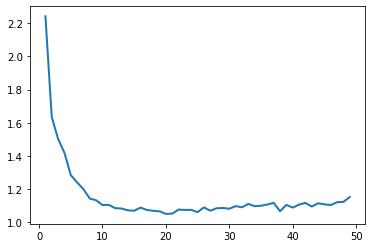

In [9]:
import matplotlib.pyplot as plt
import numpy as np
mselist.insert( 0, perf0)
# make data
x = np.linspace(1, F_N-1,F_N-1)
y = mselist
# plot
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2.0)
plt.show()

In [10]:
save_name1 = 'XGB-Stepregression_besttitles'+str(len(title[bestfeatlist]))+c_time+'.txt'
save_name2 = Path('.', DIR, save_name1)
with open(save_name2,"w") as f:
    np.savetxt(save_name2,title[bestfeatlist], fmt='%s', delimiter=',', comments='!')
f.close()